Không tìm thấy cột 'published_date', tạo dữ liệu giả lập


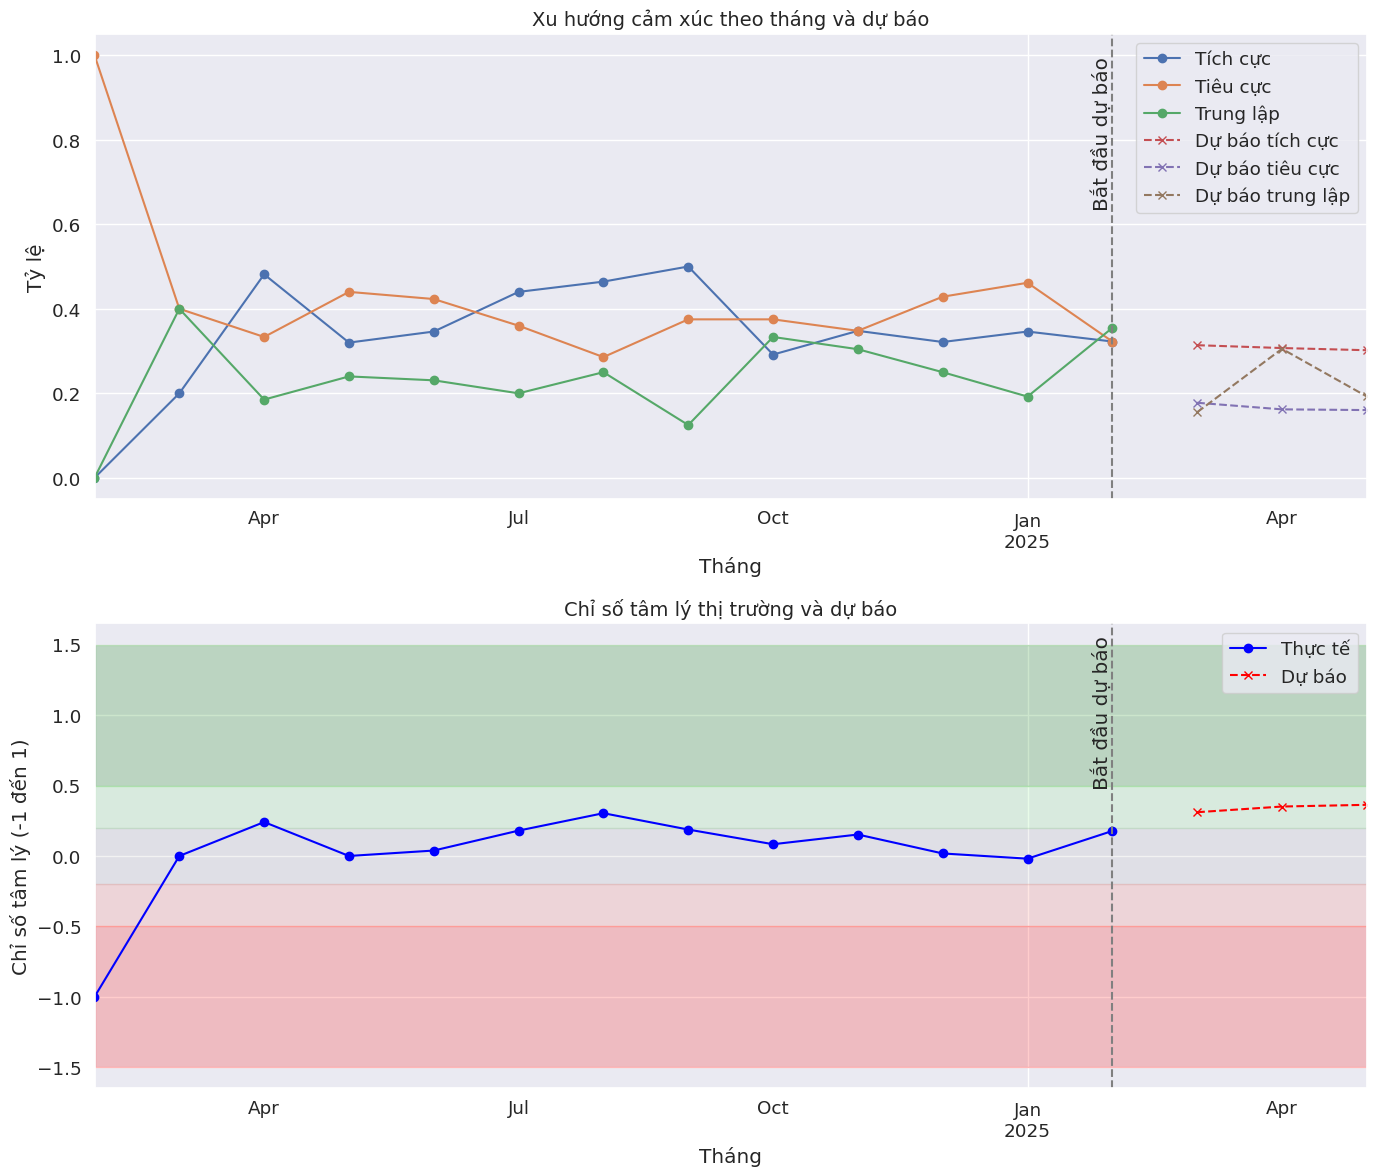

Đã lưu báo cáo dự báo vào file 'bao_cao_du_bao_thi_truong.md'

---------- TÓM TẮT DỰ BÁO ----------
Tâm lý hiện tại: Trung lập
Xu hướng dự báo 3 tháng tới: Tăng mạnh
-------------------------------------


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
import os
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Thiết lập font chữ và style cho đồ thị
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Kết nối MongoDB
mongo_uri = os.environ.get('MONGO_URI')
client = MongoClient(mongo_uri)
db = client.get_database()
collection = db['pred_news']

# Lấy dữ liệu từ collection
data = list(collection.find())
df = pd.DataFrame(data)

# Chuyển đổi trường published_date sang định dạng datetime
if 'published_date' in df.columns:
    df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
    # Loại bỏ các bản ghi không có ngày hoặc ngày không hợp lệ
    df = df.dropna(subset=['published_date'])
else:
    print("Không tìm thấy cột 'published_date', tạo dữ liệu giả lập")
    # Tạo dữ liệu giả lập nếu không có published_date
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)  # Lấy dữ liệu của 1 năm
    
    # Tạo ngẫu nhiên các ngày trong khoảng thời gian
    random_dates = [start_date + timedelta(days=np.random.randint(0, 365)) for _ in range(len(df))]
    df['published_date'] = pd.to_datetime(random_dates)

# Thêm các cột thời gian
df['year'] = df['published_date'].dt.year
df['month'] = df['published_date'].dt.month
df['week'] = df['published_date'].dt.isocalendar().week
df['year_month'] = df['published_date'].dt.strftime('%Y-%m')

# Phân tích xu hướng cảm xúc theo tháng
monthly_sentiment = df.groupby('year_month')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Đảm bảo rằng tất cả các cột tồn tại
for col in ['positive', 'negative', 'neutral']:
    if col not in monthly_sentiment.columns:
        monthly_sentiment[col] = 0

# Tính chỉ số tâm lý thị trường (MIS - Market Intelligence Score)
# MIS = % positive - % negative + (% neutral * 0.5)
monthly_sentiment['market_score'] = monthly_sentiment['positive'] - monthly_sentiment['negative'] + (monthly_sentiment['neutral'] * 0.5)

# Chuyển index sang datetime để dễ dàng phân tích xu hướng
monthly_sentiment.index = pd.to_datetime(monthly_sentiment.index + '-01')
monthly_sentiment = monthly_sentiment.sort_index()

# Function để dự báo xu hướng sử dụng ARIMA
def forecast_trend(series, periods=3):
    """
    Dự báo xu hướng sử dụng mô hình ARIMA
    
    Args:
        series: Chuỗi thời gian cần dự báo
        periods: Số kỳ cần dự báo
        
    Returns:
        forecasted_values: Các giá trị dự báo
    """
    if len(series) < 4:
        # Nếu không đủ dữ liệu, sử dụng hồi quy tuyến tính đơn giản
        model = LinearRegression()
        X = np.arange(len(series)).reshape(-1, 1)
        y = series.values
        model.fit(X, y)
        
        # Dự báo cho các kỳ tiếp theo
        future_X = np.arange(len(series), len(series) + periods).reshape(-1, 1)
        forecasted_values = model.predict(future_X)
    else:
        try:
            # Thử sử dụng ARIMA
            model = ARIMA(series, order=(1, 1, 1))
            model_fit = model.fit()
            forecasted_values = model_fit.forecast(steps=periods)
        except:
            # Fallback to linear regression if ARIMA fails
            model = LinearRegression()
            X = np.arange(len(series)).reshape(-1, 1)
            y = series.values
            model.fit(X, y)
            
            # Dự báo cho các kỳ tiếp theo
            future_X = np.arange(len(series), len(series) + periods).reshape(-1, 1)
            forecasted_values = model.predict(future_X)
    
    return forecasted_values

# Dự báo xu hướng cho 3 tháng tiếp theo
forecast_months = 3

# Tạo dữ liệu dự báo
forecast_data = {}
for col in ['positive', 'negative', 'neutral', 'market_score']:
    if len(monthly_sentiment) > 0:
        forecast_values = forecast_trend(monthly_sentiment[col], forecast_months)
        forecast_data[col] = forecast_values
    else:
        forecast_data[col] = np.zeros(forecast_months)

# Tạo DataFrame cho dữ liệu dự báo
last_date = monthly_sentiment.index[-1] if not monthly_sentiment.empty else pd.to_datetime('today')
forecast_dates = [last_date + pd.DateOffset(months=i+1) for i in range(forecast_months)]
forecast_df = pd.DataFrame(forecast_data, index=forecast_dates)

# Kết hợp dữ liệu thực tế và dự báo
combined_df = pd.concat([monthly_sentiment, forecast_df])

# Định nghĩa các hàm phân tích
def interpret_market_sentiment(score):
    """Diễn giải chỉ số tâm lý thị trường"""
    if score > 0.5:
        return "Rất tích cực"
    elif score > 0.2:
        return "Tích cực"
    elif score > -0.2:
        return "Trung lập"
    elif score > -0.5:
        return "Tiêu cực"
    else:
        return "Rất tiêu cực"

def interpret_trend(current, forecast):
    """Diễn giải xu hướng dựa trên dự báo"""
    if len(forecast) < 1:
        return "Không đủ dữ liệu để dự báo"
    
    last_value = current[-1] if len(current) > 0 else 0
    avg_forecast = np.mean(forecast)
    
    percent_change = ((avg_forecast - last_value) / max(abs(last_value), 0.01)) * 100
    
    if percent_change > 20:
        return "Tăng mạnh"
    elif percent_change > 5:
        return "Tăng nhẹ"
    elif percent_change < -20:
        return "Giảm mạnh"
    elif percent_change < -5:
        return "Giảm nhẹ"
    else:
        return "Ổn định"

# Tạo các biểu đồ và báo cáo
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# 1. Biểu đồ xu hướng cảm xúc theo tháng
ax1 = axes[0]
monthly_sentiment[['positive', 'negative', 'neutral']].plot(kind='line', ax=ax1, marker='o')

# Thêm dữ liệu dự báo vào biểu đồ (vẽ đường đứt khúc)
for col in ['positive', 'negative', 'neutral']:
    if col in forecast_df.columns:
        forecast_df[col].plot(kind='line', ax=ax1, linestyle='--', marker='x')

ax1.set_title('Xu hướng cảm xúc theo tháng và dự báo', fontsize=14)
ax1.set_ylabel('Tỷ lệ')
ax1.set_xlabel('Tháng')
ax1.legend(['Tích cực', 'Tiêu cực', 'Trung lập', 
            'Dự báo tích cực', 'Dự báo tiêu cực', 'Dự báo trung lập'])
ax1.grid(True)

# Thêm đường phân cách giữa dữ liệu thực tế và dự báo
if not monthly_sentiment.empty:
    ax1.axvline(x=monthly_sentiment.index[-1], color='gray', linestyle='--')
    ax1.text(monthly_sentiment.index[-1], ax1.get_ylim()[1] * 0.95, 'Bắt đầu dự báo', 
             rotation=90, va='top', ha='right')

# 2. Biểu đồ chỉ số tâm lý thị trường
ax2 = axes[1]
monthly_sentiment['market_score'].plot(kind='line', ax=ax2, marker='o', color='blue')

# Thêm dữ liệu dự báo vào biểu đồ
if 'market_score' in forecast_df.columns:
    forecast_df['market_score'].plot(kind='line', ax=ax2, linestyle='--', marker='x', color='red')

# Thêm vùng màu để phân biệt các mức độ tâm lý
ax2.axhspan(0.5, 1.5, color='green', alpha=0.2, label='Rất tích cực')
ax2.axhspan(0.2, 0.5, color='lightgreen', alpha=0.2, label='Tích cực')
ax2.axhspan(-0.2, 0.2, color='gray', alpha=0.1, label='Trung lập')
ax2.axhspan(-0.5, -0.2, color='salmon', alpha=0.2, label='Tiêu cực')
ax2.axhspan(-1.5, -0.5, color='red', alpha=0.2, label='Rất tiêu cực')

ax2.set_title('Chỉ số tâm lý thị trường và dự báo', fontsize=14)
ax2.set_ylabel('Chỉ số tâm lý (-1 đến 1)')
ax2.set_xlabel('Tháng')
ax2.grid(True)
ax2.legend(['Thực tế', 'Dự báo'])

# Thêm đường phân cách giữa dữ liệu thực tế và dự báo
if not monthly_sentiment.empty:
    ax2.axvline(x=monthly_sentiment.index[-1], color='gray', linestyle='--')
    ax2.text(monthly_sentiment.index[-1], ax2.get_ylim()[1] * 0.95, 'Bắt đầu dự báo', 
             rotation=90, va='top', ha='right')

plt.tight_layout()
plt.savefig('du_bao_tam_ly_thi_truong.png', dpi=300, bbox_inches='tight')
plt.show()

# Tạo báo cáo dự báo
current_month = datetime.now().strftime('%m/%Y')
forecast_months = [
    (datetime.now() + pd.DateOffset(months=i+1)).strftime('%m/%Y') 
    for i in range(forecast_months)
]

# Diễn giải tâm lý thị trường hiện tại
if not monthly_sentiment.empty:
    current_sentiment = monthly_sentiment['market_score'].iloc[-1]
    current_mood = interpret_market_sentiment(current_sentiment)
else:
    current_sentiment = 0
    current_mood = "Không đủ dữ liệu"

# Diễn giải xu hướng dự báo
trend_positive = interpret_trend(
    monthly_sentiment['positive'].values if not monthly_sentiment.empty else [], 
    forecast_df['positive'].values if 'positive' in forecast_df.columns else []
)

trend_negative = interpret_trend(
    monthly_sentiment['negative'].values if not monthly_sentiment.empty else [], 
    forecast_df['negative'].values if 'negative' in forecast_df.columns else []
)

trend_market = interpret_trend(
    monthly_sentiment['market_score'].values if not monthly_sentiment.empty else [],
    forecast_df['market_score'].values if 'market_score' in forecast_df.columns else []
)

# Tạo báo cáo markdown
report = f"""# Báo cáo dự báo xu hướng thị trường chứng khoán

## Tóm tắt tâm lý thị trường
- **Tâm lý hiện tại ({current_month})**: {current_mood} (chỉ số: {current_sentiment:.2f})
- **Xu hướng dự báo cho 3 tháng tới**: {trend_market}

## Chi tiết dự báo
- **Tin tức tích cực**: {trend_positive}
- **Tin tức tiêu cực**: {trend_negative}

## Dự báo theo tháng
"""

# Thêm chi tiết dự báo theo từng tháng
for i, month in enumerate(forecast_months):
    if 'market_score' in forecast_df.columns and len(forecast_df) > i:
        predicted_score = forecast_df['market_score'].iloc[i]
        mood = interpret_market_sentiment(predicted_score)
        positive_pct = forecast_df['positive'].iloc[i] * 100 if 'positive' in forecast_df.columns else 0
        negative_pct = forecast_df['negative'].iloc[i] * 100 if 'negative' in forecast_df.columns else 0
        neutral_pct = forecast_df['neutral'].iloc[i] * 100 if 'neutral' in forecast_df.columns else 0
        
        report += f"### Tháng {month}\n"
        report += f"- **Chỉ số tâm lý dự báo**: {predicted_score:.2f} - {mood}\n"
        report += f"- **Tin tức tích cực**: {positive_pct:.1f}%\n"
        report += f"- **Tin tức tiêu cực**: {negative_pct:.1f}%\n"
        report += f"- **Tin tức trung lập**: {neutral_pct:.1f}%\n\n"

# Thêm diễn giải và lời khuyên
report += """## Diễn giải và lời khuyên đầu tư

"""

# Thêm lời khuyên dựa trên xu hướng dự báo
if trend_market == "Tăng mạnh":
    report += """Thị trường có dấu hiệu sẽ tăng mạnh trong 3 tháng tới. Đây có thể là thời điểm tốt để:
- Xem xét **MUA VÀO** các cổ phiếu có nền tảng cơ bản tốt
- **TĂNG** tỷ trọng cổ phiếu trong danh mục đầu tư
- Tập trung vào các ngành có nhiều tin tức tích cực gần đây"""

elif trend_market == "Tăng nhẹ":
    report += """Thị trường dự báo sẽ tăng nhẹ trong thời gian tới. Nhà đầu tư có thể:
- Tiếp tục **GIỮ** các cổ phiếu hiện có
- Cân nhắc **GIA TĂNG** vị thế với các cổ phiếu tiềm năng
- Theo dõi kỹ các thông tin vĩ mô để điều chỉnh chiến lược"""

elif trend_market == "Ổn định":
    report += """Thị trường dự kiến sẽ ổn định trong thời gian tới. Lời khuyên:
- **DUY TRÌ** danh mục đầu tư hiện tại
- Xem xét các cơ hội đầu tư mới nhưng cần thận trọng
- Đa dạng hóa danh mục đầu tư để giảm thiểu rủi ro"""

elif trend_market == "Giảm nhẹ":
    report += """Thị trường có dấu hiệu giảm nhẹ trong thời gian tới. Nhà đầu tư nên:
- **THẬN TRỌNG** với các quyết định đầu tư mới
- Xem xét **GIẢM** tỷ trọng các cổ phiếu rủi ro cao
- Tập trung vào các cổ phiếu phòng thủ và có cổ tức tốt"""

elif trend_market == "Giảm mạnh":
    report += """Thị trường có nguy cơ giảm mạnh trong thời gian tới. Khuyến nghị:
- **BẢO TOÀN VỐN** là ưu tiên hàng đầu
- Xem xét việc **BÁN BỚT** các cổ phiếu đã có lãi hoặc rủi ro cao
- Tăng tỷ trọng tiền mặt để chờ đợi cơ hội tốt hơn
- Đầu tư vào các công cụ tài chính an toàn hơn"""

else:
    report += """Không đủ dữ liệu để đưa ra khuyến nghị cụ thể. Nhà đầu tư nên:
- Theo dõi sát diễn biến thị trường
- Tham khảo thêm các phân tích kỹ thuật và cơ bản khác
- Duy trì chiến lược đầu tư dài hạn"""

# Thêm lưu ý
report += """

## Lưu ý quan trọng
- Dự báo dựa trên phân tích cảm xúc từ tin tức, cần kết hợp với phân tích kỹ thuật và cơ bản
- Các sự kiện vĩ mô đột biến có thể làm thay đổi hoàn toàn xu hướng dự báo
- Đầu tư chứng khoán luôn tiềm ẩn rủi ro, nhà đầu tư cần cân nhắc kỹ trước khi ra quyết định
"""

# Lưu báo cáo
with open('bao_cao_du_bao_thi_truong.md', 'w', encoding='utf-8') as f:
    f.write(report)

print("Đã lưu báo cáo dự báo vào file 'bao_cao_du_bao_thi_truong.md'")
print("\n---------- TÓM TẮT DỰ BÁO ----------")
print(f"Tâm lý hiện tại: {current_mood}")
print(f"Xu hướng dự báo 3 tháng tới: {trend_market}")
print("-------------------------------------")